In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [2]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]
    

In [3]:
print ('n samples = ',len(names))
for x in names[::1000]:
    print(x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [4]:
#all unique characters go here
# <all unique characters in the dataset>
from functools import reduce
tokens = reduce(lambda x, y: x.union(y), [set()]+names)
tokens = list(tokens)
print('n_tokens = ', len(tokens))
print(tokens)


n_tokens =  55
['P', 'n', 'C', 'l', 'h', 's', 'm', 'Z', 'b', 'y', 'o', 'M', 'B', 'N', 'Y', 'j', 'R', 'r', 'J', '-', 'a', 'G', 'T', 'H', 'k', 'K', 'O', 'd', 't', 'W', 'p', 'U', 'X', 'z', 'u', 'v', 'w', 'f', 'D', 'L', 'I', 'e', 'F', 'Q', 'i', 'x', 'E', "'", 'g', 'A', 'S', ' ', 'q', 'c', 'V']


In [5]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i, t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i, t in enumerate(tokens)}

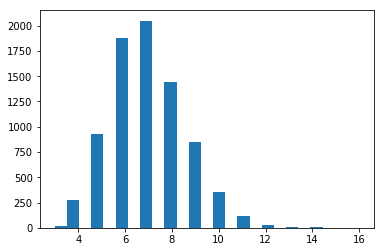

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(list(map(len, names)), bins=25);

In [7]:
# truncate names longer than MAX_LEN characters. 
MAX_LEN = 20
#you will likely need to change this for any dataset different from "names"

### Cast everything from symbols into identifiers

In [8]:
names_ix = list(map(lambda name: list(map(token_to_id.get, name)), names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len, names_ix))) == 1

names_ix = np.array(names_ix)

In [9]:
print(names_ix[:3])

[[51 49  8 20 48 20 41  3 51 51 51 51 51 51 51 51 51 51 51 51]
 [51 49  8 20 48 20 44  3 51 51 51 51 51 51 51 51 51 51 51 51]
 [51 49  8  8 41 51 51 51 51 51 51 51 51 51 51 51 51 51 51 51]]


# Input variables

In [10]:
input_sequence = T.matrix('token sequencea', 'int32')
target_values = T.matrix('actual next token', 'int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [11]:
from lasagne.layers import InputLayer, DenseLayer, EmbeddingLayer
from lasagne.layers import RecurrentLayer, LSTMLayer, GRULayer, CustomRecurrentLayer

In [12]:
EMBEDDING_SIZE = 8
HIDDEN_SIZE = 24
l_in = lasagne.layers.InputLayer(shape=(None, None), input_var=input_sequence)

#!<Your neural network>
# <embedding layer or one-hot encoding>
l_emb = EmbeddingLayer(l_in,
                       input_size=len(tokens),
                       output_size=EMBEDDING_SIZE)

# <some recurrent layer(or several such layers)>
l_rnn = LSTMLayer(l_emb,
                  num_units=HIDDEN_SIZE,
                  grad_clipping=5.)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1, l_rnn.output_shape[-1]))

# <last dense layer (or several layers), returning probabilities for all possible next tokens>
l_out = DenseLayer(l_rnn_flat,
                   num_units=len(tokens),
                   nonlinearity=lasagne.nonlinearities.softmax)

In [13]:
# Model weights
weights = lasagne.layers.get_all_params(l_out, trainable=True)
print(weights)

[W, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [14]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [15]:
from lasagne.regularization import regularize_layer_params, l2

predicted_probabilities_flat = network_output
correct_answers_flat = lasagne.utils.one_hot(target_values.ravel(), len(tokens))

# <loss function - a simple categorical crossentropy will do, maybe add some regularizer>
reg = regularize_layer_params([l_rnn, l_out], l2) * 1e-4
loss = T.mean(T.nnet.categorical_crossentropy(predicted_probabilities_flat,
                                              correct_answers_flat)) + reg

# <your favorite optimizer>
updates = lasagne.updates.adam(loss, weights, learning_rate=0.001)

# Compiling it

In [16]:
#training
train = theano.function([input_sequence, target_values],
                        loss,
                        updates=updates,
                        allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [17]:
#compile the function that computes probabilities for next token given previous text.

# reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0], 
                                           input_sequence.shape[1], len(tokens)))

# predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:, -1]
probs = theano.function([input_sequence], last_word_probas, allow_input_downcast=True)

In [18]:

def generate_sample(seed_phrase=None, N=MAX_LEN, t=1, n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = list(map(lambda c: token_to_id.get(c,0), seed_phrase))
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet.strip())
        
    print("----\n %s \n----" % '; '.join(snippets))


# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [19]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0, len(data), size=batch_size)]
    
    return rows[:,:-1], rows[:,1:]

In [20]:
print("Training ...")

#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10


for epoch in range(n_epochs):

    print( "Generated names")
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))



Training ...
Generated names
----
 gCErGIrUyMWbEZcbjCp; ZrCfmaSqoxzM-LmaVtC'; AmKfcMlWEVVMPY UXYHU; oTAXHWEdxUWhSHQbAloX; pPNHDxRDFiwikdgkXIdd; xlImQOozTFasL'IusGVb; XYnX MyIAkXHsVnKfVvT; IJakfTkdfVgwQNgOaBrA; dwl-gqLtTnNwhUj'C xa; aUKfRpHCvUlxateM'mNj 
----
Epoch 0 average loss = 1.5571671979710906
Generated names
----
 lihNSi; wiX  a; tyTr oa; hak  t; OL  o; gPadnie; wrh i  d; Cari e; hninrlli; agUoT   i  e 
----
Epoch 1 average loss = 1.1446004772359593
Generated names
----
 Franee      n; lrseAp; dDh; tJon    i; lae n; bnZ; FR t; trreeQ  in; yOlere; LvWeia 
----
Epoch 2 average loss = 1.0775628580632548
Generated names
----
 edyaia; watrleit; Ddina; Liiiie; ranl; CXirtrn; Unioi; mcid; nrc               s; OKieis 
----
Epoch 3 average loss = 1.0021226760310546
Generated names
----
 Aeessintiya; Jla-la; Eehina; Ejga; Kzblnon; Splnfe; Aiiauca; Gaaenra; S eorusi; Crnlne 
----
Epoch 4 average loss = 0.9750524173260583
Generated names
----
 Wyrilal; Harinlm; Meste ny; Sayrire; Stkr; Cgrr

Epoch 53 average loss = 0.8211570768588556
Generated names
----
 Marcie; Cima; Bridlbe; Tyrme; Etole; Moiel; Egathan; Xollina; Nean; Labion 
----
Epoch 54 average loss = 0.8225306480664223
Generated names
----
 Earre; Delina; Kontpurise; Naryr; Avanie; Groluboly; Clorel; Criggie; WaUli; ElWnie 
----
Epoch 55 average loss = 0.8263127657205556
Generated names
----
 Kalene; Jenkyn; Aripsalot; Shlacon; Tarbeys; Tyllie; Earmile; Winno; Parma; Krisna 
----
Epoch 56 average loss = 0.8187958617255415
Generated names
----
 Jethia; Egcgie; Meretl; Ferli; Erdie; Om; Tamoree; PriqMerlea; Resende; Jubbe 
----
Epoch 57 average loss = 0.8172224882220839
Generated names
----
 Mardal; TohrOn; Anelo; Cee; CaIdlinga; Alaligym; Dolisa; Branne; Heafvoy; Algevet 
----
Epoch 58 average loss = 0.8143497792197811
Generated names
----
 Tarthe; Sonelie; Leeb; EHerit; Yerfely; Waulye; Phricco; Shnyb; Jatos; Frusvia 
----
Epoch 59 average loss = 0.8216676619202351
Generated names
----
 Dole; Egdano; Lorola; Steh; 

In [21]:
generate_sample(n_snippets=100)

----
 Charara; Fulivert; Chathalla; Rozie; Cath; Nighilo; MenAndre; Nannice; Ingey; Carlien; Katsie; Vichall; Jontina; Shelloy; Hender; Galiane; Clorolica; Berginke; Safo; Frow; Dolyandre; Morngia; Rorianne; Joitidro; Jopina; Hathly; Sham; Gerlee; Gaissse; Oifaina; Panny; Soe; Kevonda; Tenatna; urakia; Shabrom; wordye; Csoba; Chons; Lilylona; han; Charanis; Blical; Matbie; Bratca; Geromene; Caryandue; Caleeanna; Jussalie; Amna; AMiste; Nondian; Rsiante; Beinette; Kelm; Krann; Willa; Lol; Jeobe; Aurotha; Joffea; Malias; Rudmine; Mary; Mafi; cef; Herienn; Thype; Darny; Kant; Brty; Eleett; Nebore; Roauhta; Marbery; Nove; Thereste; Parm; Marecetlon; Wilban; Kase; Leanoth; Arthina; Silana; Sharmenn; Remann; Orine; Gellica; Karlie; Eloeth; Rvima; Nifgane; Harfera; Des-arack; FTapken; Amrie; Saabosene; Antansh; Omia; Cley 
----


In [22]:
generate_sample(" A", n_snippets=10)

----
 Alliva; ArCoit; Ardia; Alicko; Aula; Amrrauh; Allimolpe; Arnnee; Anntha; Aletlorih 
----


In [23]:
generate_sample(" Os", n_snippets=10, t=1.0)

----
 Osnis; Ostaha; Osiar; Oslan; Ostey; Ospipre; Osba; Ostie; Osa; Osel 
----


## Homework part 1 - generate questions (4 pts)

* Apply recurrent neural networks to generate human-readable questions.
* The dataset origins from https://www.kaggle.com/c/quora-question-pairs - a recent kaggle challenge.
* The code below shows how to read the dataset
* Please download the __train dataset__ from [here](https://www.kaggle.com/c/quora-question-pairs/data)
* Avoid using test dataset as it contains artificially generated data.
* Alternatively, pick any similar dataset you like.

### [bonus] Word-level model (4+ points)

Learn to generate questions on _word_ level, generating one word per RNN iteration.

Kudos for 
* pre-training embedding layer with word2vec or similar
* using more compute-efficient softmax functions (hierarchical or sampled softmax)
* anything creative :)

In [ ]:
import pandas as pd
df = pd.read_csv("./train.csv")
df = pd.concat([df.question1,df.question2])

questions = list(set(df))
questions = filter(lambda x: type(x) is str, questions)
start_token,end_token = " ",";"
questions = [start_token+name.replace(";",",")+end_token for name in questions]

print('n samples = ',len(questions))
for x in questions[::100000]:
    print (x)